In [2]:
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
palette_colors = sns.color_palette()
%matplotlib inline

## Download the data using ArXiv API

In [ ]:
from utils.get_arxiv_preprints import df_from_query

In [ ]:
queries = ['machine learning, neural networks', 'computer science', 'biology', 'mathematics', 'physics', 'finance, economics',
        'machine learning, physics', 'machine learning, biology', 'machine learning, finance',  
           'molecule, biology', 'economics, biology', 'finance, mathematics', 
            'environment, biology', 'economics, mathematics', 'forecast, economics', 'forecast, finance']
df = pd.DataFrame(columns=['entry_id', 'title', 'abstract', 'authors', 'categories', 'pub_date', 'pdf_url'])

for query in tqdm(queries):   
    df_temp = df_from_query(query=query, num_of_results=2000, save_path=f'{query[:4]+query[-4:]}.csv')
    df = pd.concat([df, df_temp], ignore_index=True)

df.drop_duplicates(subset='title', ignore_index=True, inplace=True)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
df.to_csv("data/raw_results.csv", index=False)

In [ ]:
print("shape:", df.shape)
df.head(3)

shape: (43966, 7)


,entry_id,title,abstract,authors,categories,pub_date,pdf_url
0,http://arxiv.org/abs/1807.00297v1,Exponential Convergence of the Deep Neural Net...,We prove that for analytic functions in low di...,"Weinan E, Qingcan Wang",cs.LG stat.ML,2018-07-01,http://arxiv.org/pdf/1807.00297v1
1,http://arxiv.org/abs/1906.11755v1,Singular Value Decomposition and Neural Networks,Singular Value Decomposition (SVD) constitutes...,"Bernhard Bermeitinger, Tomas Hrycej, Siegfried...",cs.LG cs.NA math.NA stat.ML,2019-06-27,http://arxiv.org/pdf/1906.11755v1
2,http://arxiv.org/abs/2204.07697v1,Theory of Graph Neural Networks: Representatio...,"Graph Neural Networks (GNNs), neural network a...",Stefanie Jegelka,cs.LG stat.ML,2022-04-16,http://arxiv.org/pdf/2204.07697v1


## Create the labels


*   AI-ML: {'cs.LG', 'cs.AI', 'stat.ML'}
*   Computer Science : {'cs.\*'} except {'cs.LG', 'cs.AI'}
*   Physics : {'physics.\*', 'nucl-\*', 'nlin.\*', 'cond-mat.\*', 'astro-\*', 'quant-ph\*'}
*   Mathematics-Statistics : {'math.\*', 'stat.\*'} except {'stat.ML'}
*   Biology : {'q-bio.\*'}
*   Economics-Finance : {'econ.\*', 'q-fin.\*'}

**Note:** we know that there are some preprints that are not well categoriezed but we skip that detail, just to have a dataset to work with.



In [5]:
df = pd.read_csv('data/raw_results.csv')

In [6]:
print(df.shape)
df.head(4)

(43966, 7)


,entry_id,title,abstract,authors,categories,pub_date,pdf_url
0,http://arxiv.org/abs/1807.00297v1,Exponential Convergence of the Deep Neural Net...,We prove that for analytic functions in low di...,"Weinan E, Qingcan Wang",cs.LG stat.ML,2018-07-01,http://arxiv.org/pdf/1807.00297v1
1,http://arxiv.org/abs/1906.11755v1,Singular Value Decomposition and Neural Networks,Singular Value Decomposition (SVD) constitutes...,"Bernhard Bermeitinger, Tomas Hrycej, Siegfried...",cs.LG cs.NA math.NA stat.ML,2019-06-27,http://arxiv.org/pdf/1906.11755v1
2,http://arxiv.org/abs/2204.07697v1,Theory of Graph Neural Networks: Representatio...,"Graph Neural Networks (GNNs), neural network a...",Stefanie Jegelka,cs.LG stat.ML,2022-04-16,http://arxiv.org/pdf/2204.07697v1
3,http://arxiv.org/abs/1903.07378v1,On-line learning dynamics of ReLU neural netwo...,We introduce exact macroscopic on-line learnin...,"Michiel Straat, Michael Biehl",cs.LG cond-mat.dis-nn stat.ML,2019-03-18,http://arxiv.org/pdf/1903.07378v1


In [ ]:
# could do it in parallel but it is not necessary here
# use pandarallel or  https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
%%time
ml_ctg = df['categories'].apply(lambda x: bool(set(x.split(' ')) & set(['cs.LG', 'cs.AI', 'stat.ML'])))
cs_ctg = df['categories'].apply(lambda x: any( c.startswith("cs.") and (c not in ['cs.LG', 'cs.AI']) for c in x.split(' ') )) 
phys_ctg = df['categories'].apply(lambda x: any(c.startswith(tuple(['physics.', 'nucl-', 'nlin.', 'cond-mat.', 'astro-', 'quant-ph']))  for c in x.split(' '))) 
mth_ctg =  df['categories'].apply(lambda x: any((c.startswith(tuple(['math.', 'stat.']))) and (c!='stat.ML')  for c in x.split(' '))) 
bio_ctg = df['categories'].apply(lambda x: any(c.startswith('q-bio.') for c in x.split(' '))) 
fin_ctg = df['categories'].apply(lambda x: any(c.startswith(tuple(['econ.', 'q-fin.'])) for c in x.split(' '))) 

CPU times: user 360 ms, sys: 1.77 ms, total: 362 ms
Wall time: 366 ms


In [ ]:
df_labeled = df[['title', 'abstract']]
df_labeled.loc[:, 'ml'] = ml_ctg.astype('int8')
df_labeled.loc[:, 'cs'] = cs_ctg.astype('int8')
df_labeled.loc[:, 'ph'] = phys_ctg.astype('int8')
df_labeled.loc[:, 'mth'] = mth_ctg.astype('int8')
df_labeled.loc[:, 'bio'] = bio_ctg.astype('int8')
df_labeled.loc[:, 'fin'] = fin_ctg.astype('int8')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
print("shape:", df_labeled.shape)
df_labeled.head(4)

shape: (43966, 8)


,title,abstract,ml,cs,ph,mth,bio,fin
0,Exponential Convergence of the Deep Neural Net...,We prove that for analytic functions in low di...,1,0,0,0,0,0
1,Singular Value Decomposition and Neural Networks,Singular Value Decomposition (SVD) constitutes...,1,1,0,1,0,0
2,Theory of Graph Neural Networks: Representatio...,"Graph Neural Networks (GNNs), neural network a...",1,0,0,0,0,0
3,On-line learning dynamics of ReLU neural netwo...,We introduce exact macroscopic on-line learnin...,1,0,1,0,0,0


In [ ]:
df_labeled.to_csv("labeled_results.csv", index=False)

# Visualize the data

In [8]:
df_labeled = pd.read_csv('data/labeled_results.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


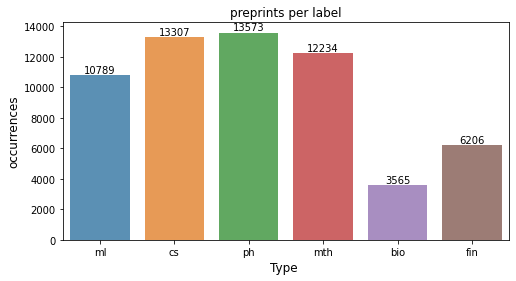

In [9]:
x = df_labeled.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("preprints per label")
plt.ylabel('occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


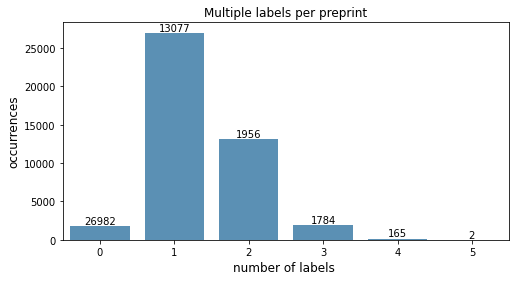

In [10]:
# Multiple tags per comment
rowsums=df_labeled.iloc[:,2:].sum(axis=1)

x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=palette_colors[0])
plt.title("Multiple labels per preprint")
plt.ylabel('occurrences', fontsize=12)
plt.xlabel('number of labels ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

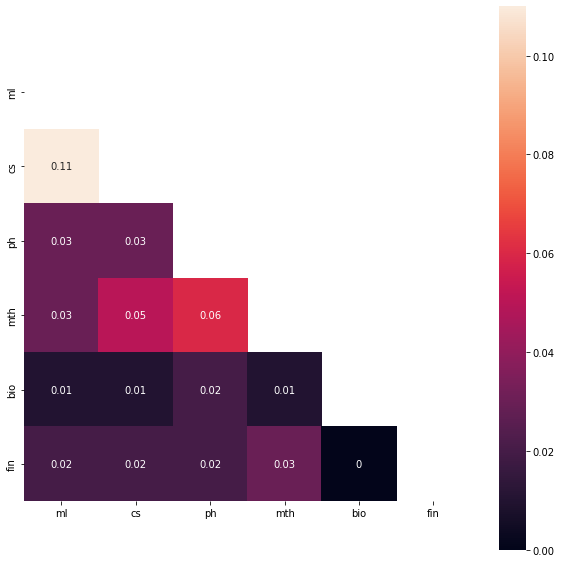

In [11]:
# create the co-occurence plot

label_cols = list(df_labeled.columns[2:])
# the labels' combinations
comb = list(itertools.combinations(label_cols, r=2))
# the percentage of co-occurrences, in the order of comb list
n_cooc = [np.round(np.mean( (df_labeled[lb[0]]==1) & (df_labeled[lb[1]]==1) ), 2)  for lb in comb]
# create the matrix of the percentage from co-occurrences, we leave the upper triangular zero because we will not use it
cooc_matrix = pd.DataFrame(np.zeros([6,6]), columns=label_cols, index=label_cols)
for i in range(len(comb)): cooc_matrix.loc[comb[i][1], comb[i][0]] = n_cooc[i]

# plot it
plt.figure(figsize=(10,10))
mask = np.zeros_like(cooc_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cooc_matrix, mask=mask, square=True, annot=True)
plt.show()

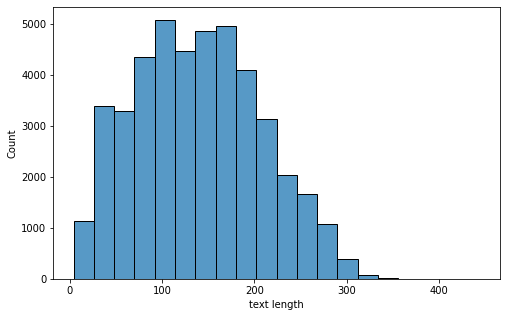

In [30]:
df_labeled['text'] = df_labeled['title'] + df_labeled['abstract']
df_labeled['text length'] = df_labeled['text'].str.split().apply(len)
plt.figure(figsize=(8,5))
sns.histplot(df_labeled, x='text length', bins=20)
plt.show()

## Create Train/Validation/Test splits

We will split Train/Test with 80/20. Then we will create 5-folds cross validation sets.

In [7]:
df_labeled = pd.read_csv('data/labeled_results.csv')

df_labeled = df_labeled.loc[df_labeled[list(df_labeled.columns[2:])].sum(axis=1) != 0]
df_labeled = df_labeled.sample(frac=1).reset_index(drop=True)
df_labeled['text'] = df_labeled['title'] + df_labeled['abstract']
data = df_labeled[['text', 'ml', 'cs', 'ph', 'mth', 'bio', 'fin']]

In [ ]:
# train/test split
train_set_percentage = 0.8
df_train = data[:int(train_set_percentage*len(data))]
df_test  = data[int(train_set_percentage*len(data)):]
print(df_train.shape, df_test.shape)

df_test.to_csv("data/test_set.csv", index=False)

In [ ]:
# source by Abhishek Thakur: https://www.kaggle.com/abhishek/30-days-create-folds
from sklearn.model_selection import KFold
df_train["kfold"] = -1
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train)):
    df_train.loc[valid_indicies, "kfold"] = fold

df_train.to_csv("data/train_5folds.csv", index=False)

In [ ]:
df_train.head()

In [ ]:
def get_fold(df, fold):
    
    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    ytrain = xtrain.iloc[:, 1:-1]
    yvalid = xvalid.iloc[:, 1:-1]
    xtrain = xtrain['text']
    xvalid = xvalid['text'] 
    return xtrain, ytrain, xvalid, yvalid

xtrain, ytrain, xvalid, yvalid = get_fold(df=df_train, fold=0)
print((xtrain.shape, ytrain.shape), (xvalid.shape, yvalid.shape))